In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

# Load File
url = 'JetRail.csv'
df = pd.read_csv(url)
df.info()

df.Datetime = pd.to_datetime(df.Datetime,format='%Y-%m-%d %H:%M') 
df.index = df.Datetime
df_jet = df.drop(['Datetime','ID'], axis = 1)
print(df_jet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
Datetime    494 non-null object
ID          494 non-null float64
Count       494 non-null float64
dtypes: float64(2), object(1)
memory usage: 11.7+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2012-08-25 to 2013-12-31
Data columns (total 1 columns):
Count    494 non-null float64
dtypes: float64(1)
memory usage: 7.7 KB
None


In [0]:
from math import sqrt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#Set up plot functions
def plt_(dataset):    
    plt.figure(figsize=(12,6))
    plt.plot(dataset, color = 'b')
    plt.show()
    
def density_plt_(dataset):
    plt.figure(figsize=(12,6))
    sns.distplot(dataset)
    plt.show()
    
#Decomposition
def decomp_plt_(dataset):
    decomposition = seasonal_decompose(dataset)
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()

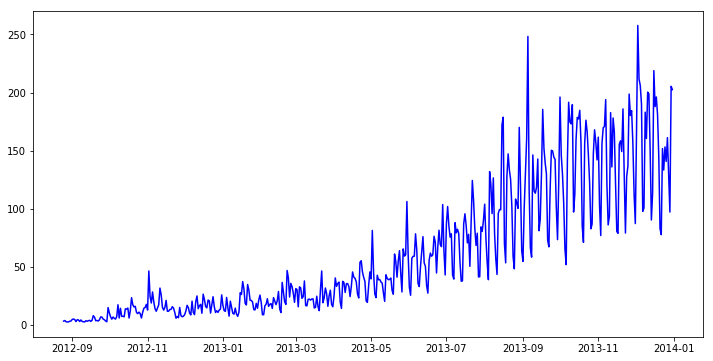

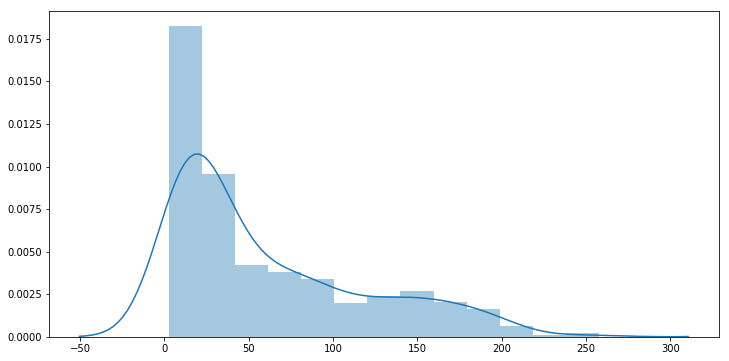

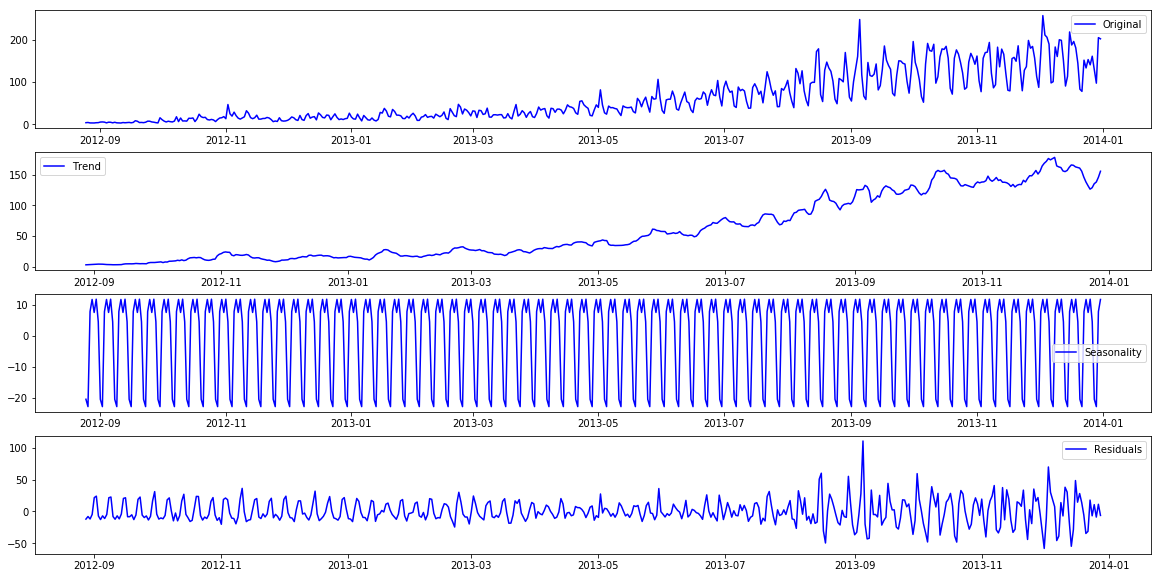

In [12]:
#JetRail EDA
plt_(df_jet)
density_plt_(df_jet)
decomp_plt_(df_jet)

In [13]:
#Checking if the data is stationary or not
def stationarity_test(dataset):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(dataset, autolag = 'AIC')
    dftest_output = pd.Series(dftest[0:2], index = ['Test statistic', 'p_value'])
#    for keys, values in dftest[4].items():
#        dftest_output['critical value (%s)' %keys] = values 
    return dftest_output

stationarity_test(df_jet[df_jet.columns[0]])

Results of Dickey-Fuller Test:


Test statistic    0.165688
p_value           0.970270
dtype: float64

Results of Dickey-Fuller Test:
Test statistic   -1.994093
p_value           0.289169
dtype: float64
Results of Dickey-Fuller Test:
Test statistic   -7.683676e+00
p_value           1.480931e-11
dtype: float64


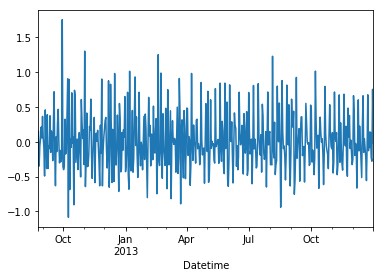

In [15]:
# Transform log
print(stationarity_test(np.log(df_jet[df_jet.columns[0]])))
# Not working

# Differencing: taking the differece with a particular time lag
df_jet_diff = np.log(df_jet[df_jet.columns[0]]).diff().dropna()
print(stationarity_test(df_jet_diff))
df_jet_diff.plot()

In [0]:
#Split Train Test
import math
total_size=len(df)
split = 10392 / 11856
train_size=math.floor(split*total_size)
train=df.head(train_size)
test=df.tail(len(df) -train_size)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


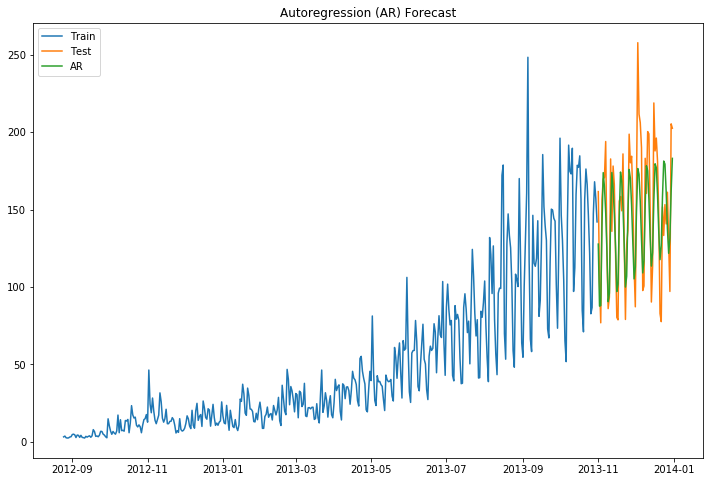

RMSE = 28.635096626807403


In [0]:
# AR Model

from statsmodels.tsa.ar_model import AR
model = AR(train.Count)
fit1 = model.fit()
y_hat = test.copy()
y_hat['AR'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['AR'], label='AR')
plt.legend(loc='best')
plt.title("Autoregression (AR) Forecast")
plt.show()

#calculating RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.AR))
print('RMSE = '+str(rms))

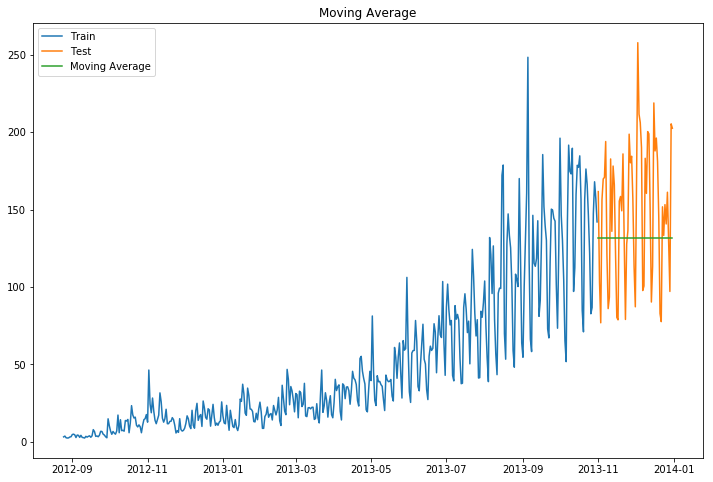

RMSE = 46.728407251069626


In [0]:
# Moving average

# Create prediction table
y_hat = test.copy()
# Create Moving Average from last 60 periods
y_hat['moving_avg'] = train['Count'].rolling(60).mean().iloc[-1]

#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['moving_avg'], label='Moving Average')
plt.legend(loc='best')
plt.title("Moving Average")
plt.show()

#RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.moving_avg))
print('RMSE = '+str(rms))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


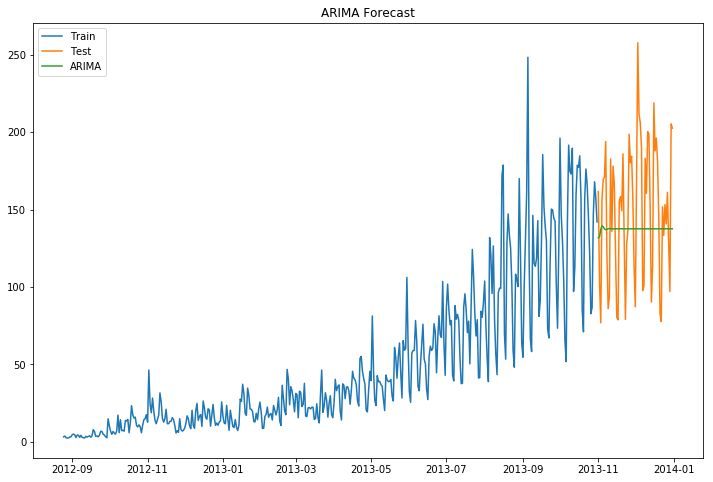

RMSE = 44.854339194797255


In [5]:
#ARIMA Model

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.Count, order=(3, 0, 1))
fit1 = model.fit(disp=False)
y_hat = test.copy()
y_hat['ARIMA'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.title("ARIMA Forecast")
plt.show()

#calculating RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.ARIMA))
print('RMSE = '+str(rms))